In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")  # avoid printing out absolute paths

In [60]:
from scripts.data_builder import HydroForecastData

import glob
import pandas as pd
import xarray as xr

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import (TimeSeriesDataSet, TemporalFusionTransformer,
                                 Baseline)
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss, SMAPE, RMSE
from pytorch_forecasting.metrics.base_metrics import MultiHorizonMetric

torch.set_float32_matmul_precision('medium')

In [3]:
static_attributes = pd.read_csv('/workspaces/my_dissertation/geo_data/attributes/static_data.csv',
                                index_col='gauge_id')
static_attributes.index = static_attributes.index.astype(str)
static_attributes = static_attributes[['for_pc_sse', 'crp_pc_sse',
                                       'inu_pc_ult', 'ire_pc_sse',
                                       'lka_pc_use', 'prm_pc_sse',
                                       'pst_pc_sse', 'cly_pc_sav',
                                       'slt_pc_sav', 'snd_pc_sav',
                                       'kar_pc_sse', 'urb_pc_sse',
                                       'gwt_cm_sav', 'lkv_mc_usu',
                                       'rev_mc_usu', 'sgr_dk_sav',
                                       'slp_dg_sav', 'ws_area', 'ele_mt_sav']]

In [4]:
def open_for_tft(file_path: str,
                 attributes: pd.DataFrame) -> pd.DataFrame:
    
    gauge_id = file_path.split('/')[-1][:-3]
    
    gauge_static = attributes.loc[[gauge_id], :]
    
    file = xr.open_dataset(file_path)
    file = file.to_dataframe()
    # file['date'] = file.index
    file = file.reset_index()
    file['time_idx'] = file.index
    
    for col in gauge_static.columns:
        file[col] = gauge_static[col].values[0]
        
    return file

file = pd.concat(open_for_tft(file,
                              static_attributes)
                 for file in glob.glob('../geo_data/time_series/*.nc')[6:10])
file = file.reset_index(drop=True)

In [5]:
# define dataset
encoder_length = 365
prediction_length = 7
training_cutoff = "2016-12-31"  # day for cutoff

In [75]:
training = TimeSeriesDataSet(
    data=file[lambda x: x.date <= training_cutoff],  # type: ignore
    time_idx="time_idx",
    target="q_cms_s",
    group_ids=["gauge_id"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["q_cms_s"],
    max_encoder_length=encoder_length,
    max_prediction_length=prediction_length,
    static_reals=['for_pc_sse', 'crp_pc_sse',
                  'inu_pc_ult', 'ire_pc_sse',
                  'lka_pc_use', 'prm_pc_sse',
                  'pst_pc_sse', 'cly_pc_sav',
                  'slt_pc_sav', 'snd_pc_sav',
                  'kar_pc_sse', 'urb_pc_sse',
                  'gwt_cm_sav', 'lkv_mc_usu',
                  'rev_mc_usu', 'sgr_dk_sav',
                  'slp_dg_sav', 'ws_area', 'ele_mt_sav'],
    time_varying_known_reals=['t_max_e5l', 't_min_e5l', 'prcp_e5l'],
    target_normalizer=GroupNormalizer(
        groups=["gauge_id"], transformation="softplus"),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True)
# create validation set (predict=True) which means
# to predict the last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(training, file,
                                            predict=True,
                                            stop_randomization=True)
# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True,
                                          batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False,
                                          batch_size=batch_size * 10,
                                          num_workers=0)

### Baseline model

In [76]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

3.9521427154541016

### Find optimal learning rate

In [ ]:
class SMAPE(MultiHorizonMetric):
    """
    Symmetric mean absolute percentage. Assumes ``y >= 0``.

    Defined as ``2*(y - y_pred).abs() / (y.abs() + y_pred.abs())``
    """

    def loss(self, y_pred, target):
        y_pred = self.to_prediction(y_pred)
        loss = 2 * (y_pred - target).abs() / (y_pred.abs() + target.abs() + 1e-8)
        return loss

In [51]:
class MALELoss(MultiHorizonMetric):
        
    def loss(self, y_pred, target):
        
        y_pred = self.to_prediction(y_pred)
        
        return torch.mean(torch.abs(torch.log(y_pred) - torch.log(target)))


In [65]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=4,
    dropout=0.2,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=1,  # 7 quantiles by default
    loss=RMSE(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
    optimizer='adam')

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 34.7k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at /workspaces/my_dissertation/forecast/.lr_find_e525a84f-78a7-4721-b09c-8d809b01925d.ckpt
Restored all states from the checkpoint file at /workspaces/my_dissertation/forecast/.lr_find_e525a84f-78a7-4721-b09c-8d809b01925d.ckpt


suggested learning rate: 0.0014125375446227544


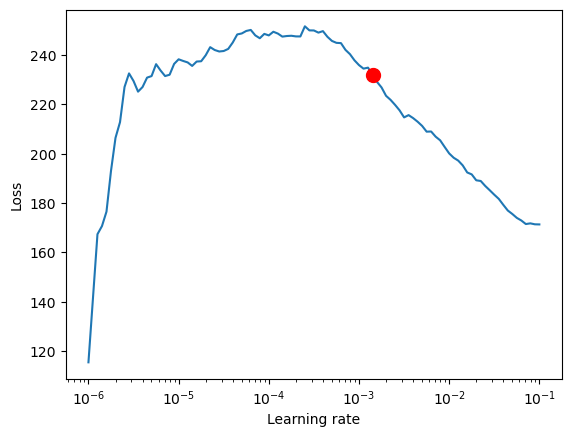

In [66]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=0.1,
    min_lr=1e-6)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [68]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss",
                                    min_delta=1e-4, patience=10,
                                    verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=6,
    accelerator='gpu', devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    # coment in for training, running valiation every 30 batches
    limit_train_batches=30,
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=28,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=1,  # 7 quantiles by default
    loss=RMSE(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 73.1k


In [69]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 432   
4  | static_variable_selection          | VariableSelectionNetwork        | 23.2 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.5 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 3.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 3.3 K 
9  | static_context_initial_cell_lstm 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=6` reached.


In [70]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=1,
    max_epochs=6,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2023-03-26 21:04:47,467] A new study created in memory with name: no-name-322bec91-ebe1-4703-bfb0-e538bba6372f
/opt/conda/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=6` reached.
[I 2023-03-26 21:05:50,652] Trial 0 finished with value: 7.440282344818115 and parameters: {'gradient_clip_val': 0.03643298275317318, 'hidden_size': 96, 'dropout': 0.22708489777488675, 'hidden_continuous_size': 16, 'attention_head_size': 4, 'learning_rate': 0.016919406500622253}. Best is trial 0 with value: 7.440282344818115.


{'gradient_clip_val': 0.03643298275317318, 'hidden_size': 96, 'dropout': 0.22708489777488675, 'hidden_continuous_size': 16, 'attention_head_size': 4, 'learning_rate': 0.016919406500622253}


In [74]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(37.9804)

In [78]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader,
                                      mode="raw", return_x=True)

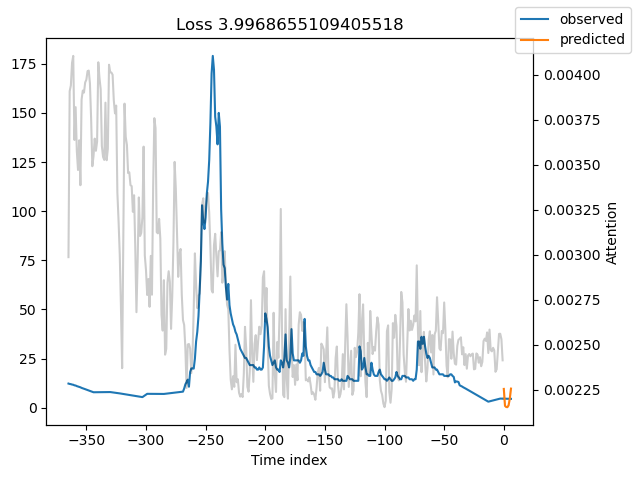

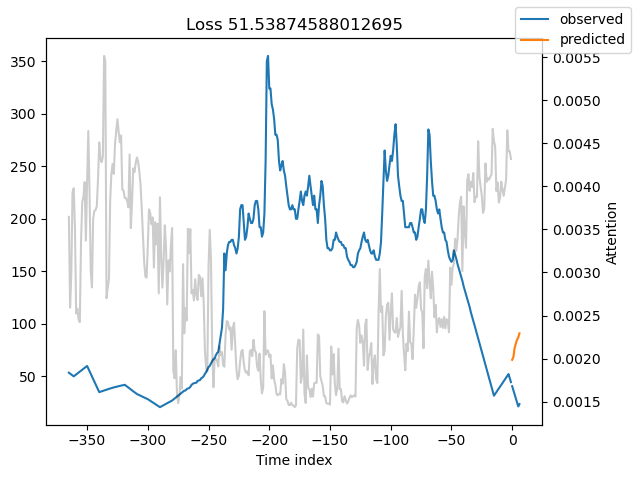

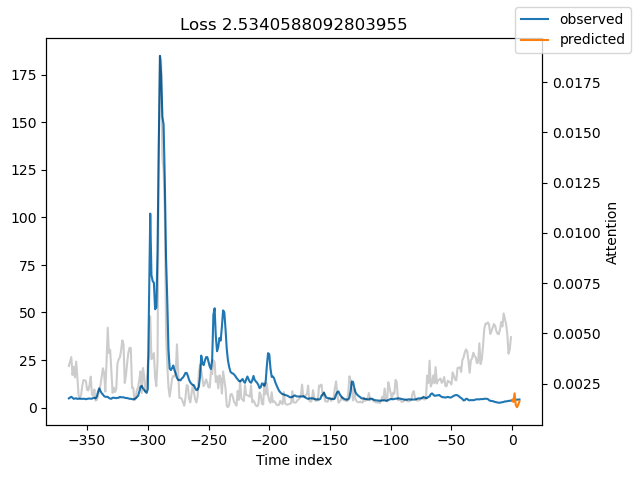

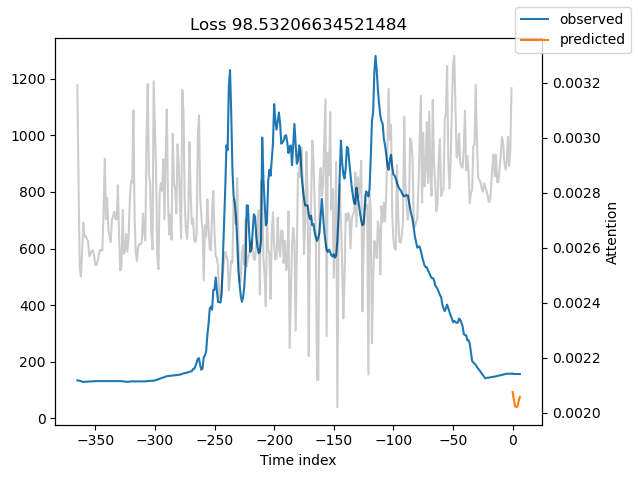

In [81]:
for idx in range(4):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx,
                             add_loss_to_title=True);

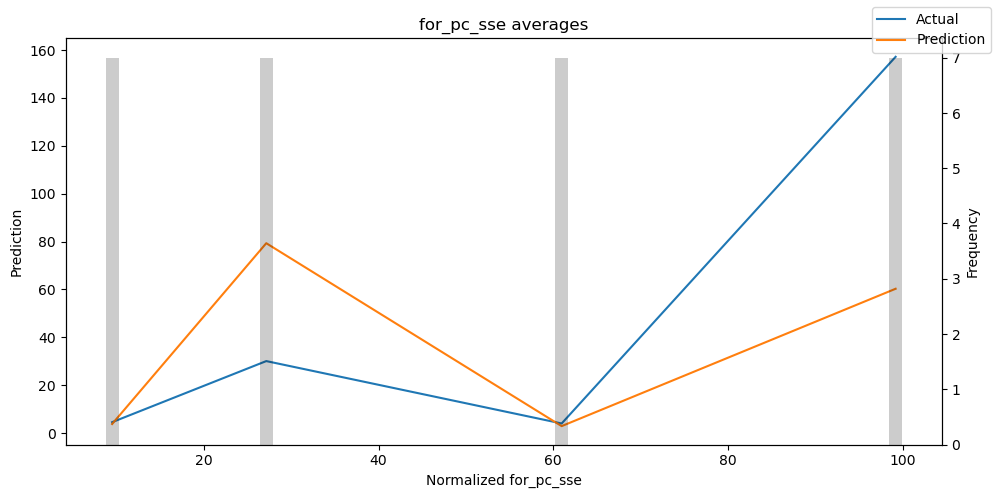

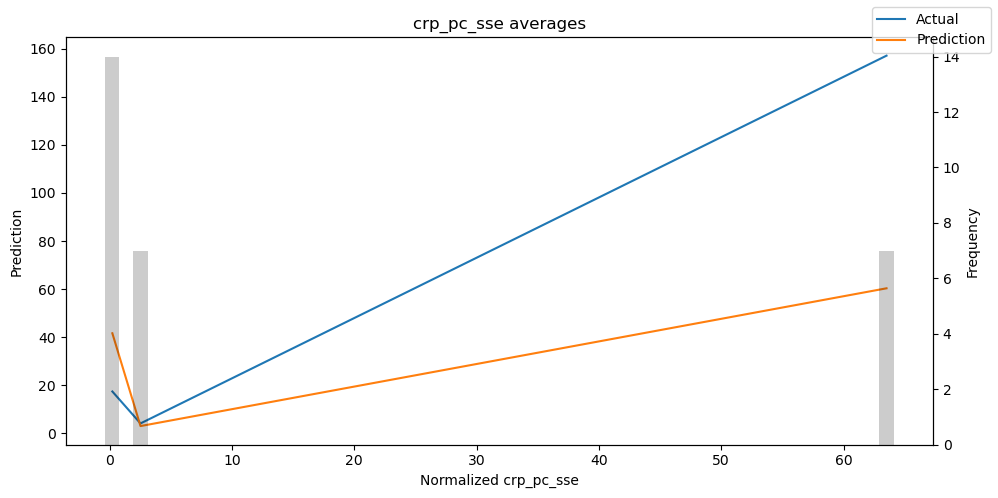

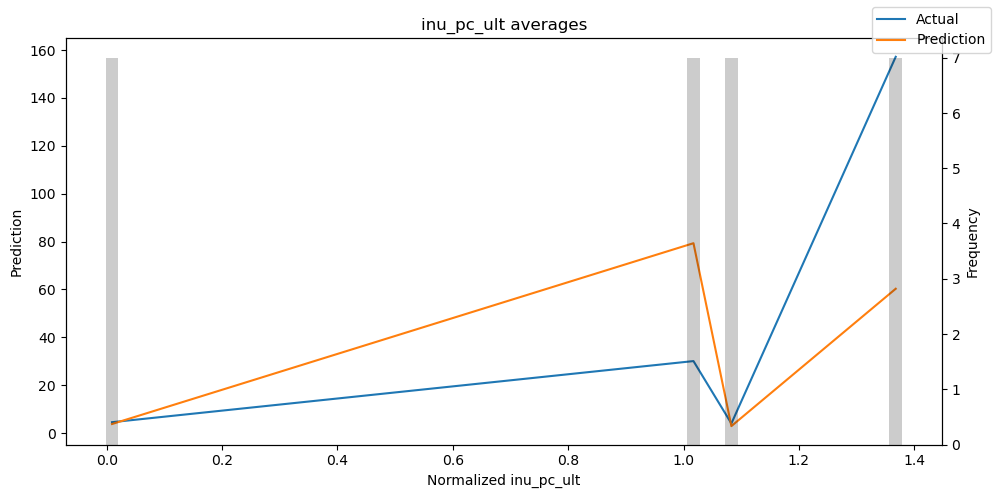

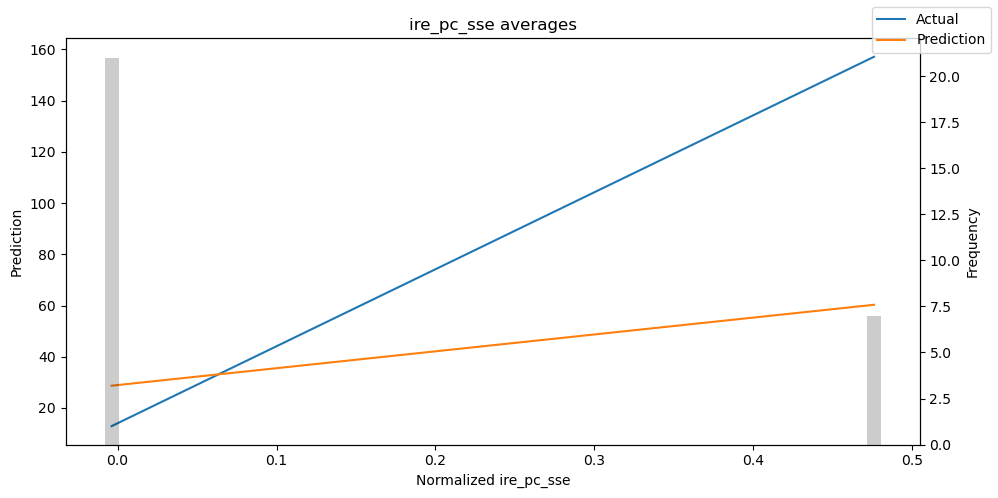

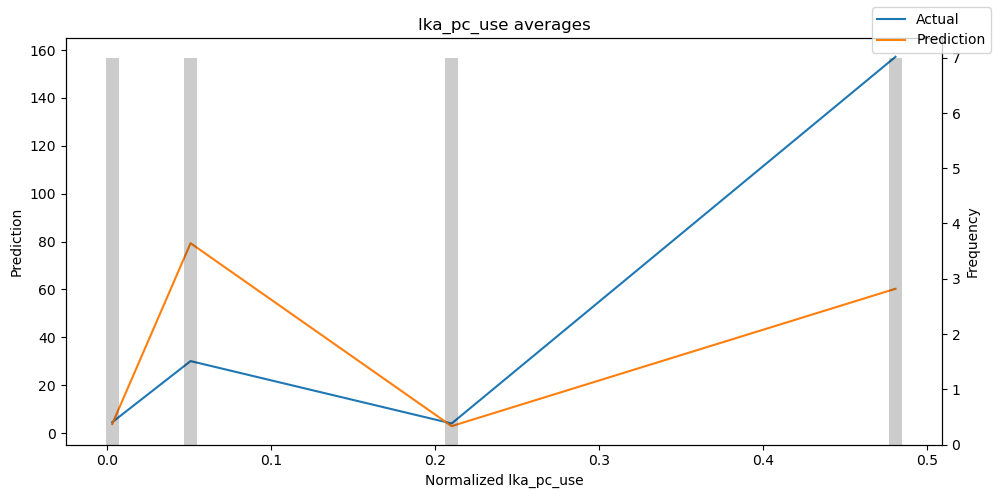

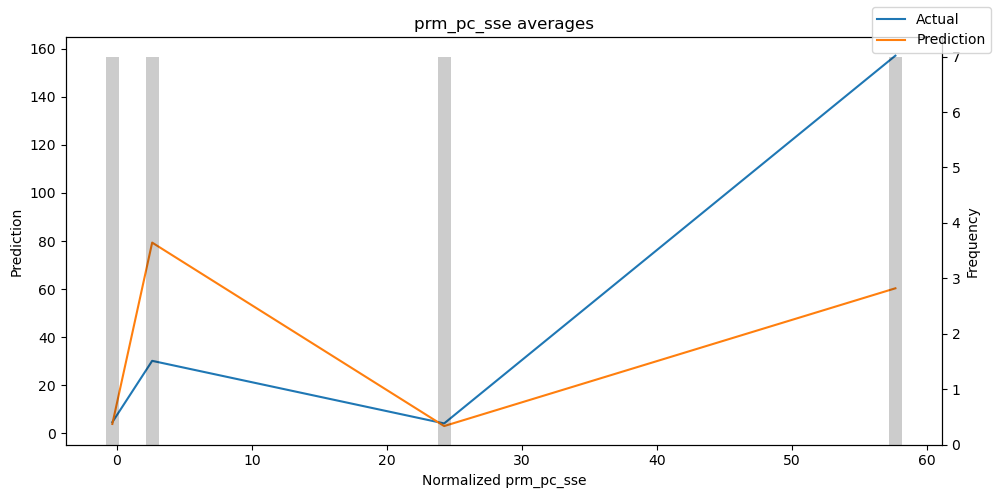

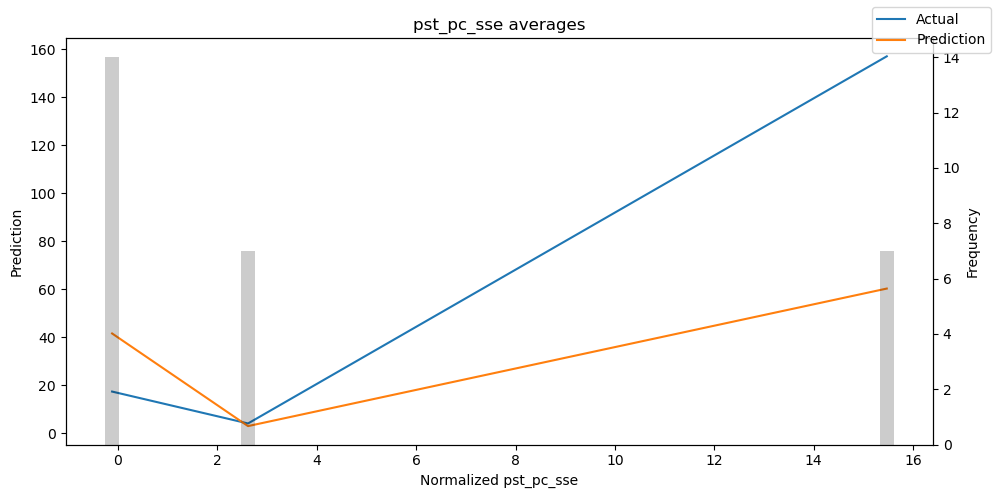

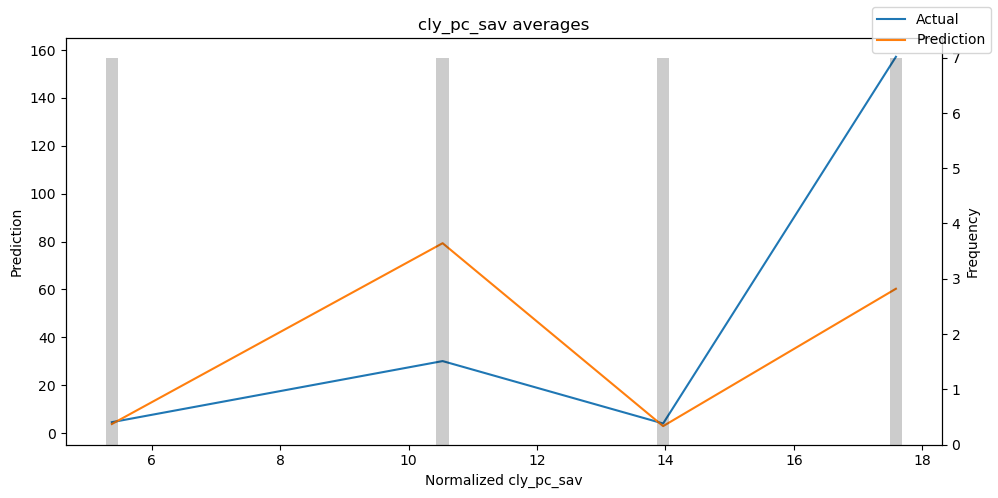

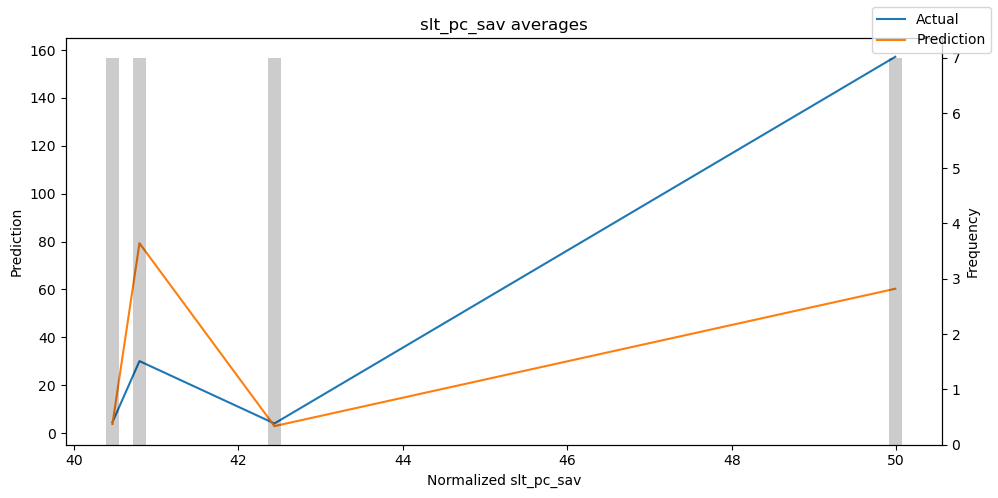

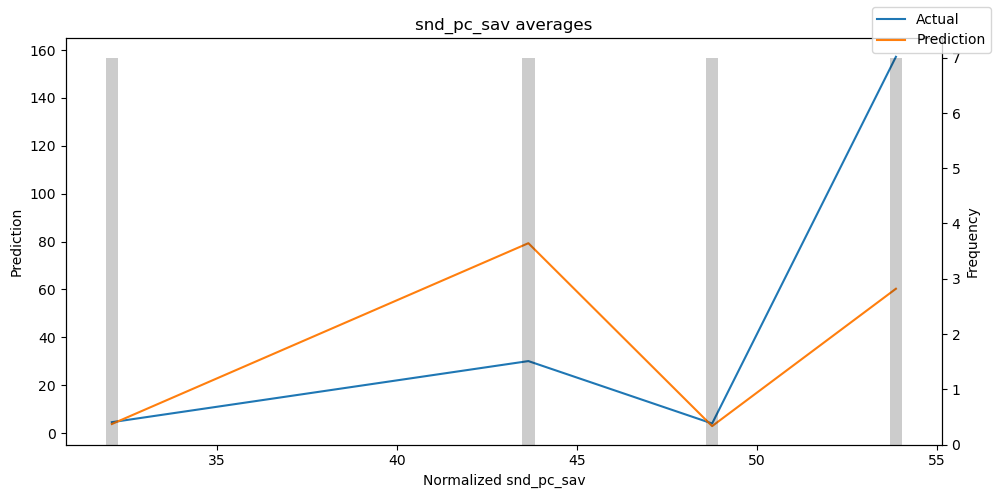

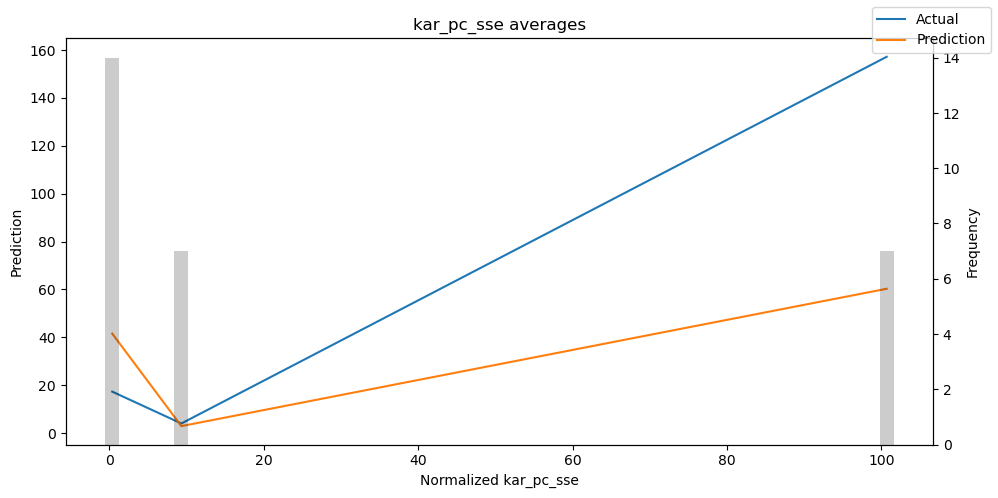

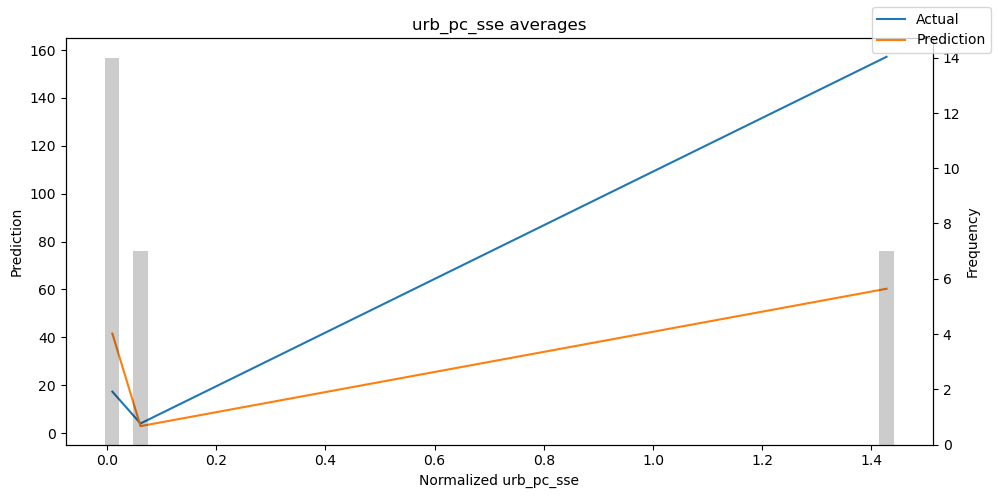

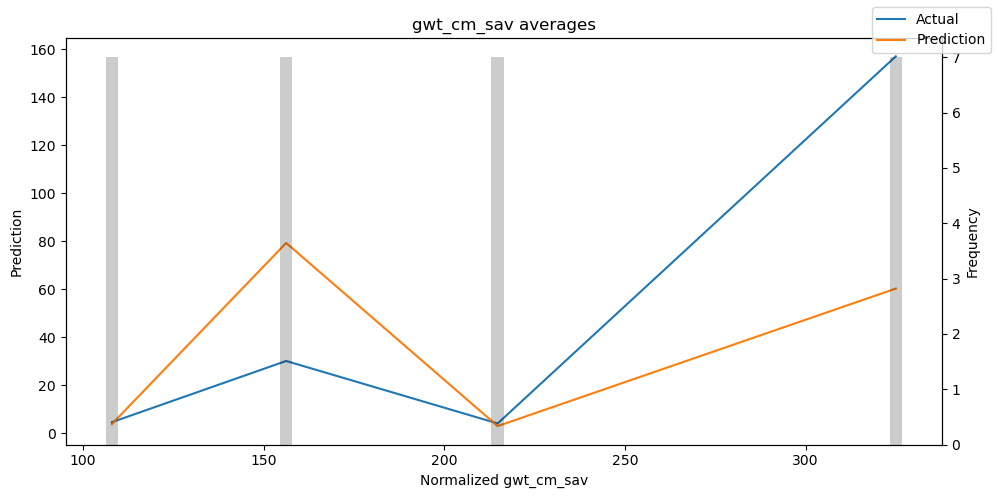

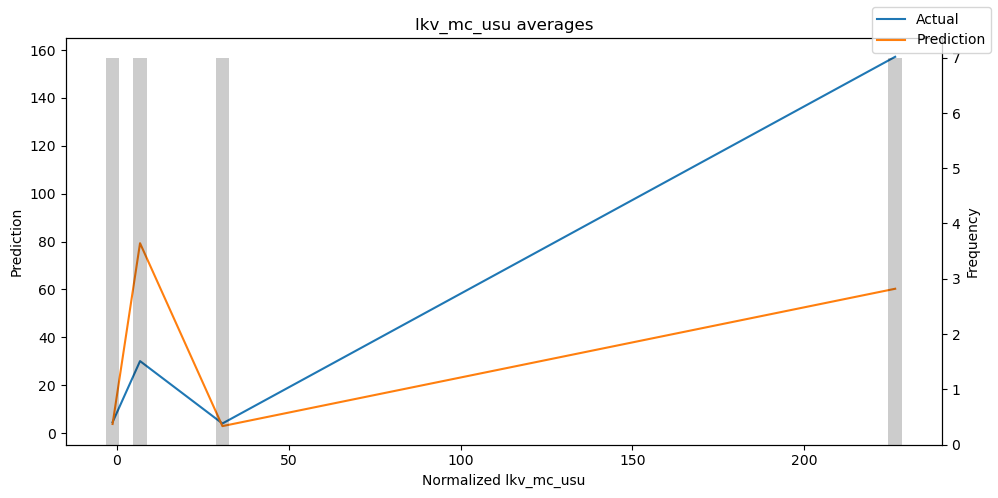

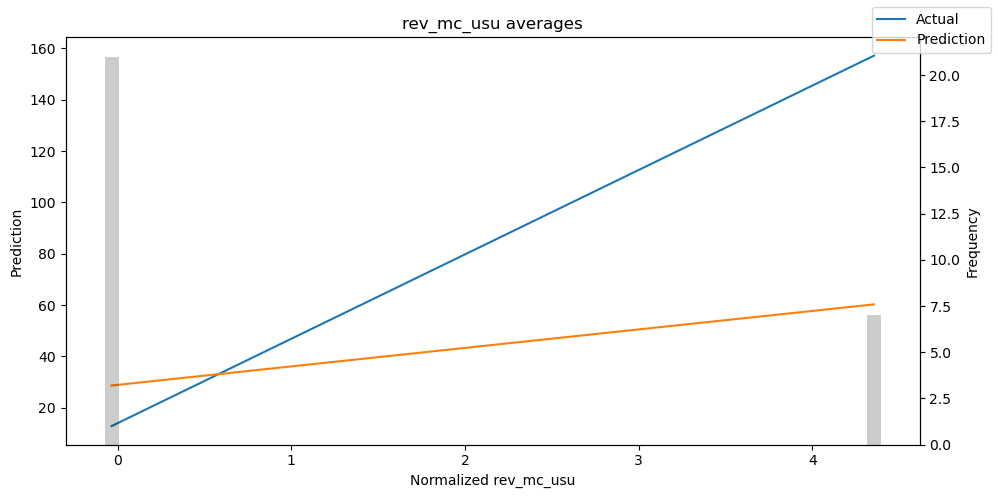

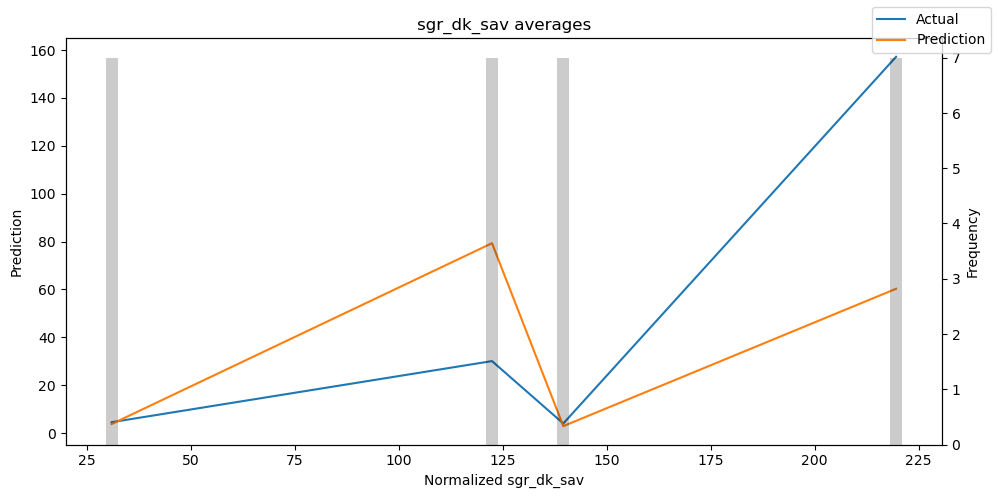

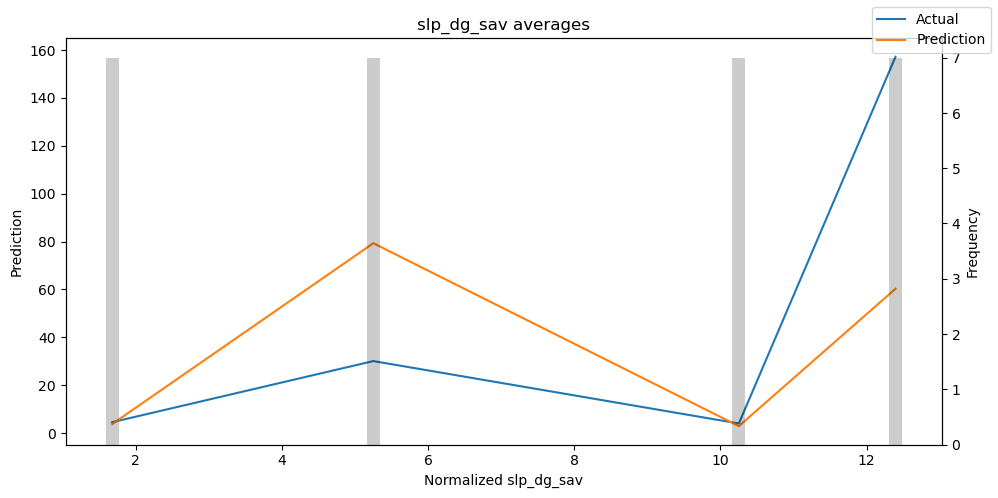

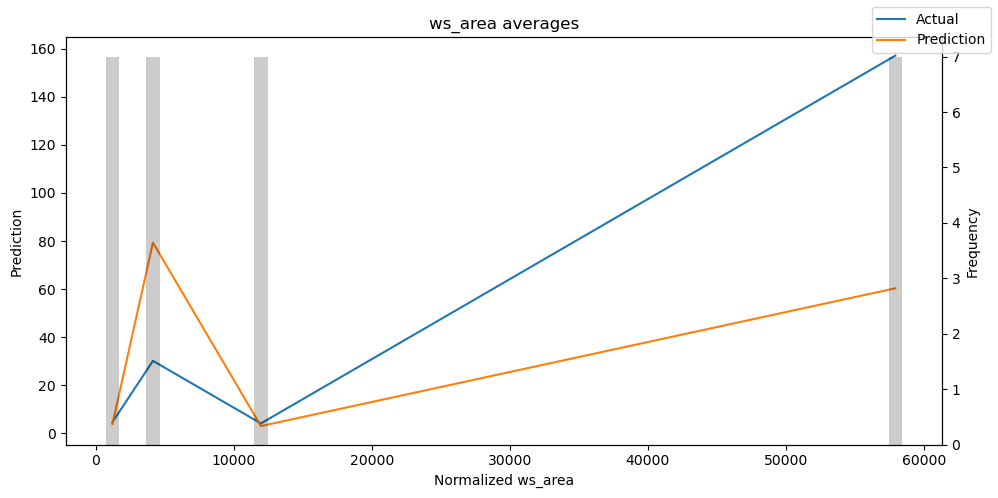

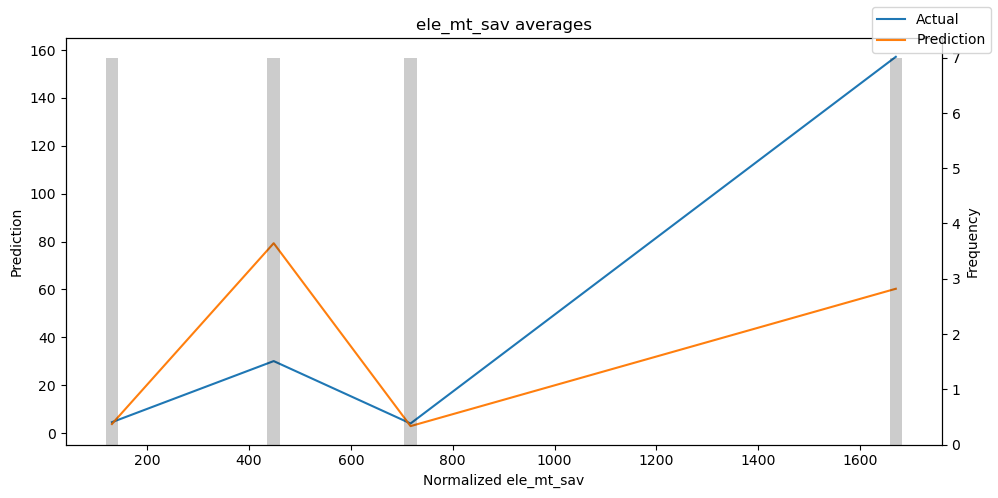

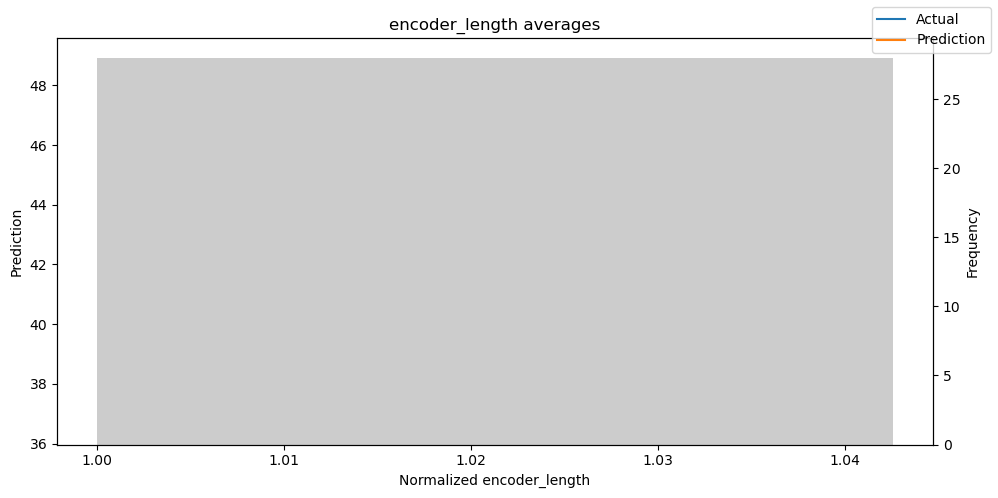

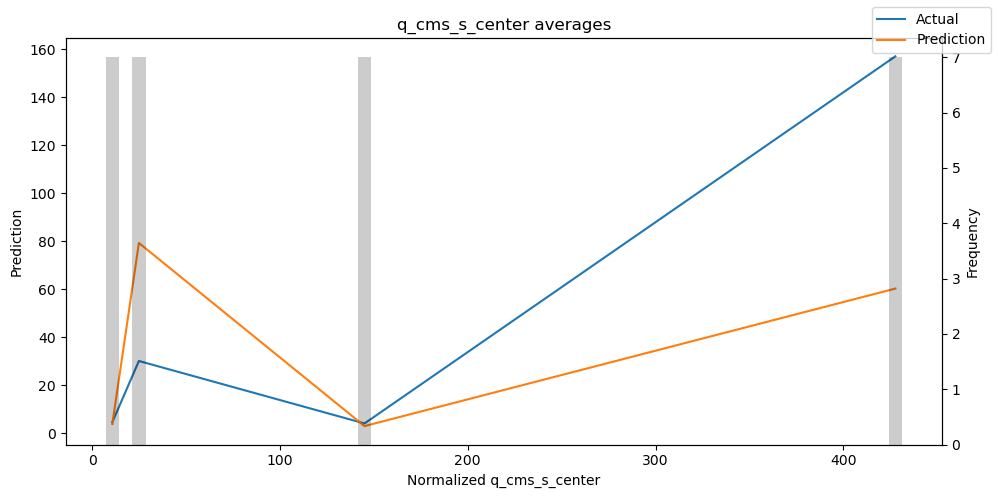

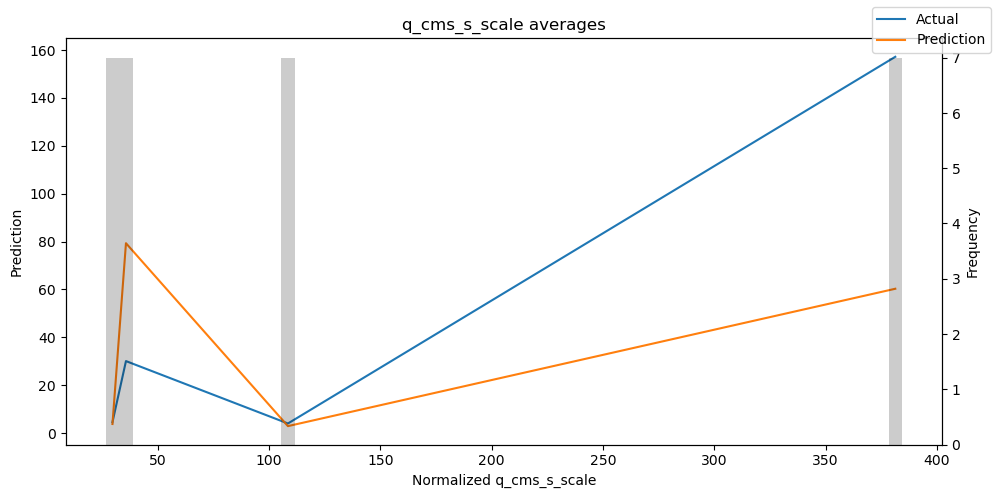

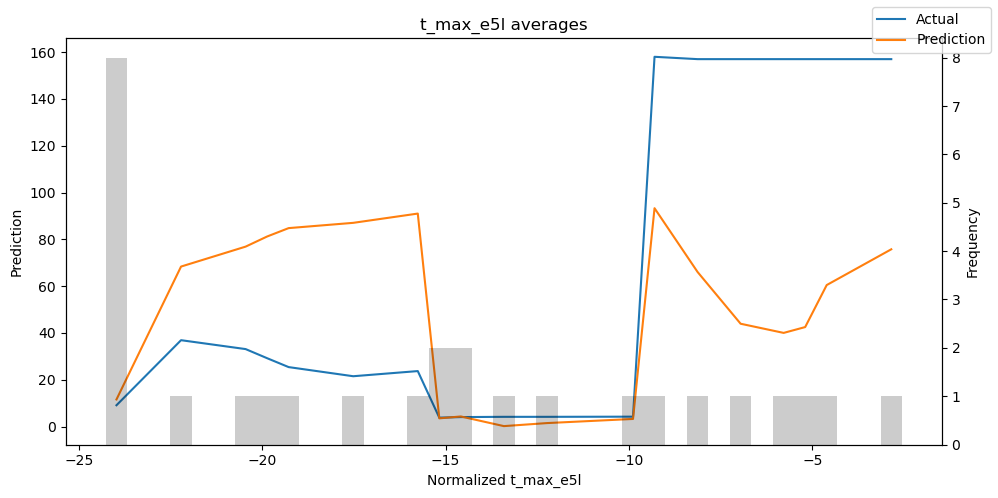

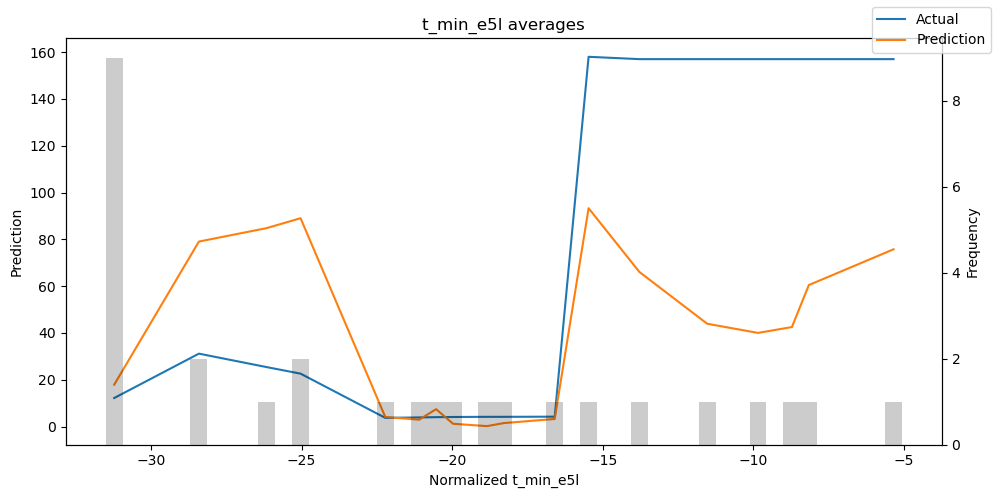

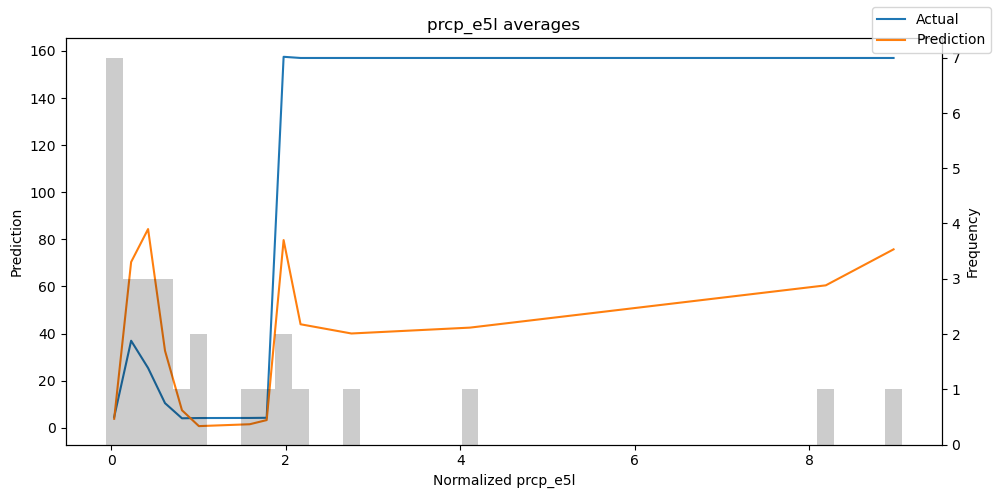

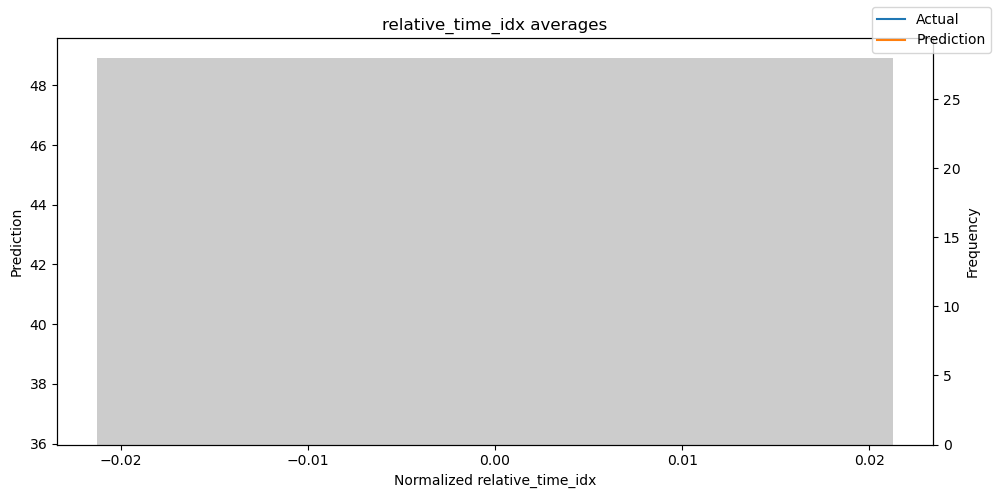

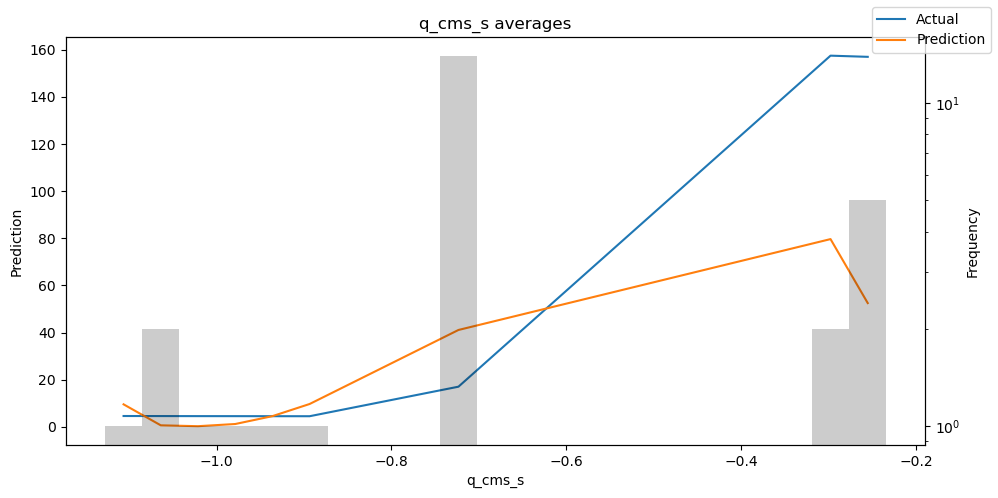

In [83]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x750 with 1 Axes>,
 'encoder_variables': <Figure size 700x325 with 1 Axes>,
 'decoder_variables': <Figure size 700x300 with 1 Axes>}

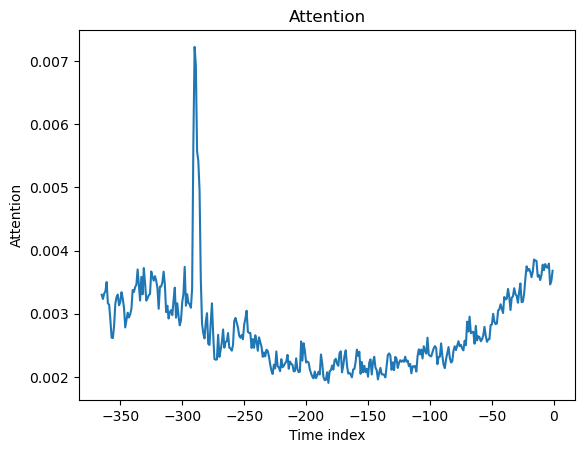

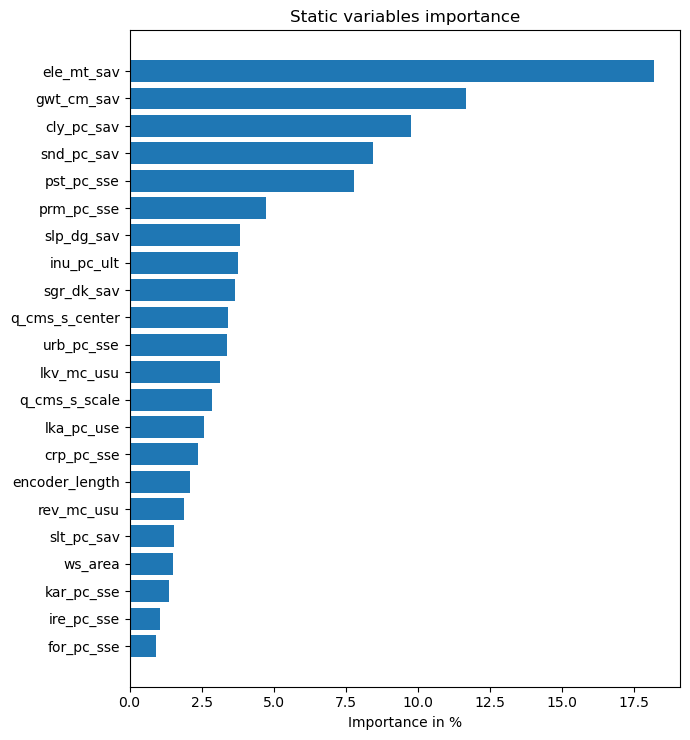

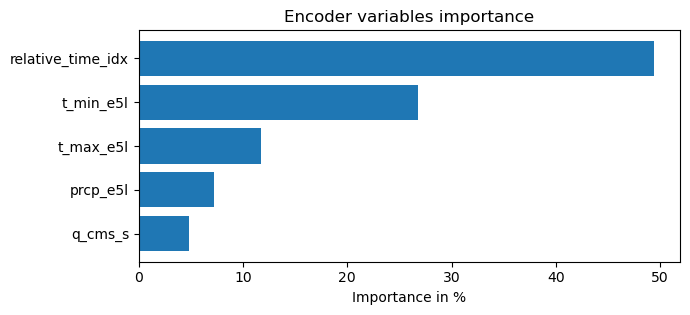

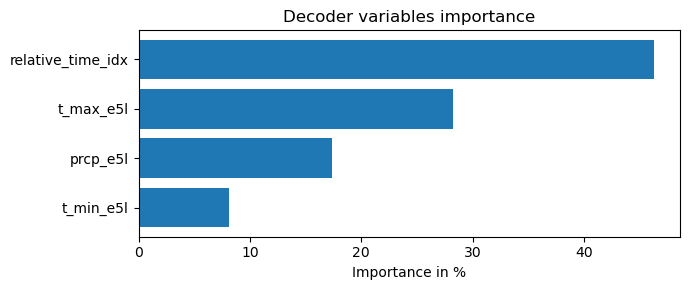

In [87]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [ ]:
geo_folder = '../geo_data/great_db'

forecast_data = HydroForecastData(
    nc_files=glob.glob(f'{geo_folder}/nc_concat/*.nc')[:5],
    gauges=['5746', '3159', '8376'],
    predictors=['t_max_e5l', 't_min_e5l', 'prcp_e5l'],
    target=['lvl_sm'],
    hydroatlas_path='../geo_data/static_attributes/geo_vector.csv',
    hydroatlas=['for_pc_sse', 'crp_pc_sse', 'inu_pc_ult',
                'ire_pc_sse', 'lka_pc_use', 'prm_pc_sse',
                'pst_pc_sse', 'cly_pc_sav', 'slt_pc_sav',
                'snd_pc_sav', 'kar_pc_sse', 'urb_pc_sse',
                'gwt_cm_sav', 'lkv_mc_usu', 'rev_mc_usu',
                'sgr_dk_sav', 'slp_dg_sav', 'ws_area',
                'ele_mt_sav'],
    h_bs_file='../ais_parsers/data/height_gauge.csv',
    future_interval=7, past_interval=365,
    train_start='01/01/2008', train_end='12/31/2015',
    val_start='01/01/2016', val_end='12/31/2018',
    test_start='01/01/2019', test_end='12/31/2020')
# store static data for further concat in decoder
static_attributes = forecast_data.static_attributes
# Here we are defining properties for our model

# Training batch size
BATCH_SIZE = 128
# so called torch Datasets
train_ds, val_ds, test_ds = forecast_data.train_val_test()
# Split the data according to our split ratio and load each subset into a
# separate DataLoader object
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, drop_last=True)

dataloaders = {x: dl for x, dl
               in zip(['train', 'val', 'test'],
                      [train_loader, val_loader, test_loader])}
datasizes = {x: len(dl) for x, dl in dataloaders.items()}
# Observe that all parameters are being optimized
# Device selection (CPU | GPU)
USE_CUDA = torch.cuda.is_available()
device = 'cuda' if USE_CUDA else 'cpu'
print(f"We'll utlize {device} in further calculations")

We'll utlize cpu in further calculations
